In [1]:
import numpy as np
from scipy import integrate as integ
from turing_model import TuringModel as tm
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress
from scipy import signal as signal
import seaborn as sns
from matplotlib.lines import Line2D

Dispersal-rate aus patch x für Heterotroph i: d_Hi_x = d_max/(1+exp(ki*Gx)), mit Gx = e*a*Ax/(1+a*h*Ax) - D.

In [2]:
# set parameters
S = 4.8 # Nutrient supply concentration
D = 0.3 # Dilution rate
N_h = 1.5 # half saturation constant for nutrient uptake
r_max = 0.7 # growth rate of autotroph
h = 0.53 # handling time
e = 0.33 # conversion efficiency of competitor
d_N = 1 # Dispersal rate of nutrients 
d_A = 0.001 # dispersal rate of autotrophs

# competitiveness 
a_1 = 1 # attack rate of competitor 1 
a_2 = 1 # attack rate of competitor 2 

def slow(var, t):
    # fill var
    N_a = var[0]
    N_b = var[1]
    A_a = var[2]
    A_b = var[3]
    H_1a = var[4]
    H_1b = var[5]
    H_2a = var[6]
    H_2b = var[7]
    g_1a = var[8]
    g_1b = var[9]
    g_2a = var[10]
    g_2b = var[11]

    # growth rate of autotrophs
    r_a = (r_max * N_a) / (N_h + N_a)
    r_b = (r_max * N_b) / (N_h + N_b)

    # growth rate of competitors
    g_1a = (a_1 * A_a) / (1 + a_1 * h * A_a)
    g_1b = (a_1 * A_b) / (1 + a_1 * h * A_b)
    g_2a = (a_2 * A_a) / (1 + a_2 * h * A_a)
    g_2b = (a_2 * A_b) / (1 + a_2 * h * A_b)

    # inflection points
    Gx = e * a_1 * A_a/(1+a_1 * h * A_a) - D
    Gy = e * a_1 * A_b/(1+a_1 * h * A_b) - D
    
    # dispersal rates of competitors
    d_H1a = d_Hmax1 / (1 + np.exp(k_1 * Gx))
    d_H1b = d_Hmax1 / (1 + np.exp(k_1 * Gy))
    d_H2a = d_Hmax2 / (1 + np.exp(k_2 * Gx))
    d_H2b = d_Hmax2 / (1 + np.exp(k_2 * Gy))

    # change of nutrients
    dN_a = D * (S - N_a) - r_a * A_a + d_N * (N_b - N_a)
    dN_b = D * (S - N_b) - r_b * A_b + d_N * (N_a - N_b)

    # change of autotrophs
    dA_a = r_a * A_a - ((g_1a * H_1a) + (g_2a * H_2a)) - D * A_a + d_A * (A_b - A_a)
    dA_b = r_b * A_b - ((g_1b * H_1b) + (g_2b * H_2b)) - D * A_b + d_A * (A_a - A_b)

    # change of competitors
    dH_1a = e * g_1a * H_1a - D * H_1a - d_H1a * H_1a + d_H1b * H_1b
    dH_1b = e * g_1b * H_1b - D * H_1b - d_H1b * H_1b + d_H1a * H_1a
    dH_2a = e * g_2a * H_2a - D * H_2a - d_H2a * H_2a + d_H2b * H_2b
    dH_2b = e * g_2b * H_2b - D * H_2b - d_H2b * H_2b + d_H2a * H_2a

    return(dN_a, dN_b, dA_a, dA_b, dH_1a, dH_1b, dH_2a, dH_2b, g_1a, g_1b, g_2a, g_2b)

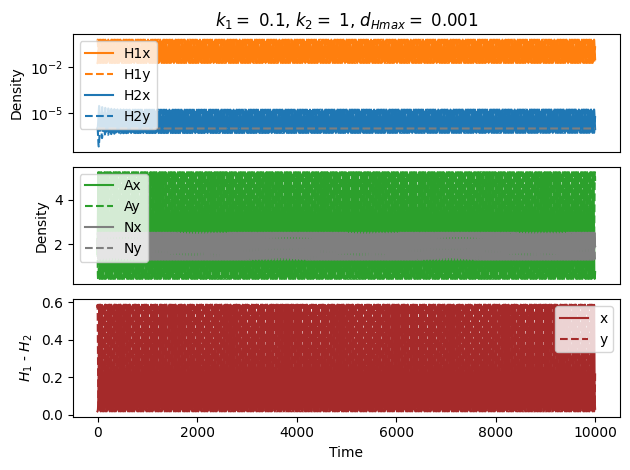

In [3]:
fig, (ax1,ax2,ax3)=plt.subplots(3)
#fig, ax1=plt.subplots()
t_end = 1000
number_steps = 1000
t1 = np.linspace(0, t_end, number_steps)


#var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.8, 0.4, 0, 0, 0, 0, 0, 0]
#var0 = [2, 2.5, 2.5, 2, 0.8, 0.4, 0.08, 0.3, 0, 0, 0, 0, 0, 0]
#var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 10**-6, 10**-6, 0, 0, 0, 0, 0, 0]
start = 0
end = 10000

var = []
k_1 = 10**-1
k_2 = 10**0
d_Hmax1 = 10**-3
d_Hmax2 = 10**-3
var = integ.odeint(slow, var0, t1)
t_end = 10000
number_steps = 10000
t = np.linspace(0, t_end, number_steps)
var00 = [var[-1,0], var[-1,1], var[-1,2], var[-1,3], var[-1,4], var[-1,5], 10**-6, 10**-6, 0, 0, 0, 0]
var = integ.odeint(slow, var00, t)

# ax1.plot(t[start:end], (var[start:end, 4]/(var[start:end, 4]+var[start:end, 5])), label="H1 flow",color="tab:red")
# ax1.plot(t[start:end], (var[start:end, 6]/(var[start:end, 6]+var[start:end, 7])), label="H2 flow",color="tab:red")
ax1.plot(t[start:end], var[start:end, 4], label="H1x",color="tab:orange")
ax1.plot(t[start:end], var[start:end, 5], label="H1y",color="tab:orange", linestyle="--")
ax1.plot(t[start:end], var[start:end, 6], label="H2x",color="tab:blue")
ax1.plot(t[start:end], var[start:end, 7], label="H2y",color="tab:blue", linestyle="--")
ax1.plot(t[start:end], np.ones(len(t[start:end]))*10**-6, color="tab:grey", linestyle="--")
ax1.set_yscale("log")
# ax1.set_xlim(10005,10075)
ax1.set_title("$k_1 = $ " + str(k_1) + ", $k_2 = $ " + str(k_2) + ", $d_{Hmax} = $ " + str(d_Hmax1))
ax1.get_xaxis().set_visible(False)
# ax1.get_yaxis().set_visible(False)
# ax1.yaxis.set_ticklabels([])
ax1.set_ylabel("Density")
ax1.legend(loc="upper left")
# ax1.set_ylim(10**-6, 10**0)
ax2.plot(t[start:end], var[start:end:, 2], label="Ax",color="tab:green")
ax2.plot(t[start:end], var[start:end:, 3], label="Ay",color="tab:green", linestyle="--")
ax2.plot(t[start:end], var[start:end:, 0], label="Nx",color="tab:grey")
ax2.plot(t[start:end], var[start:end:, 1], label="Ny",color="tab:grey", linestyle="--")
ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)
# ax2.get_xaxis().set_ticks([])
# ax2.get_yaxis().set_ticks([])
ax2.set_xlabel("Time")
ax2.set_ylabel("Density")
# ax2.set_xlim(10005,10075)
ax2.legend(loc="upper left")
ax3.plot(t[start:end], var[start:end, 4]-var[start:end, 6], label="x",color="brown")
ax3.plot(t[start:end], var[start:end, 5]-var[start:end, 7], label="y",color="brown", linestyle="--")
ax3.set_xlabel("Time")
ax3.set_ylabel("$H_1$ - $H_2$")
ax3.legend()
# ax3.set_yscale("log")
plt.tight_layout()

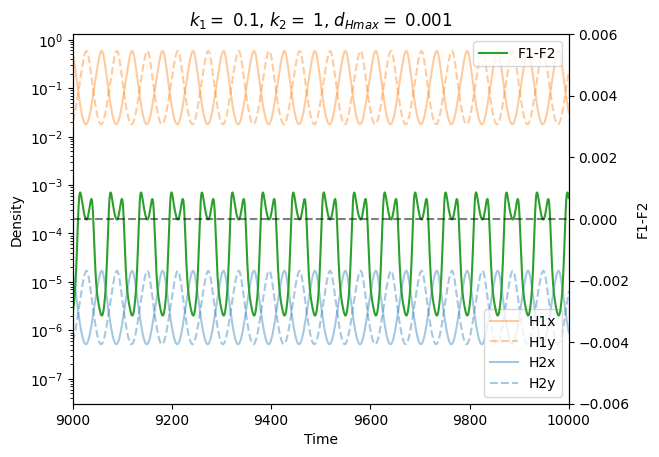

In [4]:
F1_gx = var[start:end, 8]
F1_gy = var[start:end, 9]
F1_H1x = var[start:end, 4]
F1_H1y = var[start:end, 5]

F1 = F1_gx * (F1_H1x/(F1_H1x+F1_H1y)) + F1_gy * (F1_H1y/(F1_H1x+F1_H1y))

F2_gx = var[start:end, 10]
F2_gy = var[start:end, 11]
F2_H2x = var[start:end, 6]
F2_H2y = var[start:end, 7]

F2 = F2_gx * (F2_H2x/(F2_H2x+F2_H2y)) + F2_gy * (F2_H2y/(F2_H2x+F2_H2y))
# np.mean(F1-F2)

fig, ax1=plt.subplots(1)
ax1.plot(t[start:end], var[start:end, 4], label="H1x",color="tab:orange", alpha=0.4)
ax1.plot(t[start:end], var[start:end, 5], label="H1y",color="tab:orange", linestyle="--", alpha=0.4)
ax1.plot(t[start:end], var[start:end, 6], label="H2x",color="tab:blue", alpha=0.4)
ax1.plot(t[start:end], var[start:end, 7], label="H2y",color="tab:blue", linestyle="--", alpha=0.4)
ax1.set_yscale("log")
ax1.legend(loc="lower right")
ax1.set_title("$k_1 = $ " + str(k_1) + ", $k_2 = $ " + str(k_2) + ", $d_{Hmax} = $ " + str(d_Hmax1))
# plot F1-F2 on second y axis
ax2 = ax1.twinx()
ax2.plot(t[start:end], F1 - F2, label="F1-F2", color="tab:green")
ax2.set_ylabel("F1-F2")
ax2.legend(loc="upper right")
# ax2.set_ylim(-0.075, 0.075)
ax2.set_ylim(-0.006, 0.006)
# line at y = 0
ax1.set_xlim(9000,10000)
ax2.axhline(0, color="black", alpha=0.5, linestyle="--")
ax1.set_xlabel("Time")
ax1.set_ylabel("Density")
plt.show()

In [28]:
num_extr = 40
H2_extr = []
H2_extr.append(find_maxima(np.log(var[:, 6])+np.log(var[:, 6]),num_extr))
linregress(np.linspace(1, 20, 20),H2_extr[0][20:num_extr])[0]

0.001235491041080046

k  seems to start being detrimental at some point between $>10^1$ & $<10^2$

In [18]:
def find_maxima(x,n):
    """ returns an array with n extreme values of x"""
    
    max_index = signal.argrelmax(x)[0]         # create array with indices of local maxima of x
    
    #ext_index = np.append(max_index)           # array with indices of local extrema in x
    #ext_index = np.sort(ext_index)             # sort array (alternating minima and maxima)
    extrema = x[max_index]                     # array with the actual values of the extrema
       
    if len(extrema) == 0:                      # if all values in x are the same and no extremum is found:
        extrema = np.append(extrema,x[-1])     #   return last value of x in this case
    while len(extrema) < n:                    # if less than n extrema have been found:
        extrema = np.append(extrema,extrema[0])#   repeat last extremum until array has n elements
    while len(extrema) > n:                    # if more than n extrema have been found:
        extrema = np.delete(extrema,-1)        #   delete elements until arrays has n elements
        
    return extrema

In [33]:
t_end = 3000
number_steps = 3000
t1 = np.linspace(0, t_end, number_steps)

# dispersal adaptability
k_1_range = np.geomspace(10**-1, 10**2, 25)#50
k_2_range = np.geomspace(10**-1, 10**2, 25)#50

# maximum dispersal rate
d_Hmax1 = 10**-4
d_Hmax2 = 10**-4

var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0, 0, 0, 0, 0, 0]


num_extr = 40 # set number of maxima to be found

H1_extr = []
H2_extr = []

slopeH1 = np.zeros((len(k_1_range), len(k_2_range)))
slopeH2 = np.zeros((len(k_1_range), len(k_2_range)))
var = []

i = 0
j = 0

for k_2 in tqdm(k_2_range):
    j = 0
    for k_1 in k_1_range:
        var = integ.odeint(slow, var0, t1)

        t_end = 10000
        number_steps = 10000
        t = np.linspace(0, t_end, number_steps)
        var00 = [var[-1,0], var[-1,1], var[-1,2], var[-1,3], var[-1,4], var[-1,5], 10**-6, 10**-6, 0, 0, 0, 0]
        var = integ.odeint(slow, var00, t)
    



        H1_extr.append(find_maxima(np.log(var[:, 4])+np.log(var[:, 5]),num_extr))
        H2_extr.append(find_maxima(np.log(var[:, 6])+np.log(var[:, 6]),num_extr))

        # results[i,j] = ...
        slopeH1[i, j] = linregress(np.linspace(1, 20, 20),H1_extr[0][20:num_extr])[0]
        slopeH2[i, j] = linregress(np.linspace(1, 20, 20),H2_extr[0][20:num_extr])[0]

        # workaround to empty lists
        H1_extr = []
        H2_extr = []

        j += 1
    i += 1


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [15:31<00:00, 37.26s/it]


<Axes: >

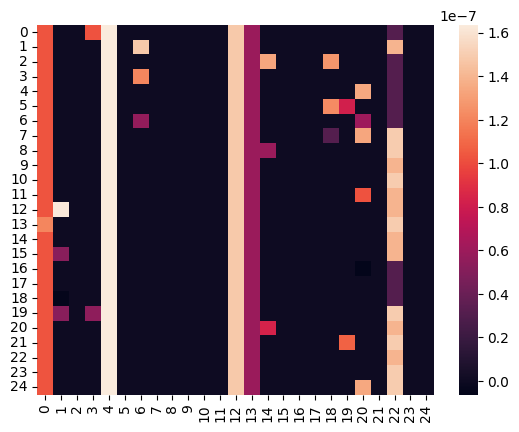

In [31]:
#plt.contourf(slopeH1)
sns.heatmap(slopeH1)

Text(0.5, 1.0, 'Growth rate of $H_2$ \n $d_{H_{max}} = $10-3, H2 invader')

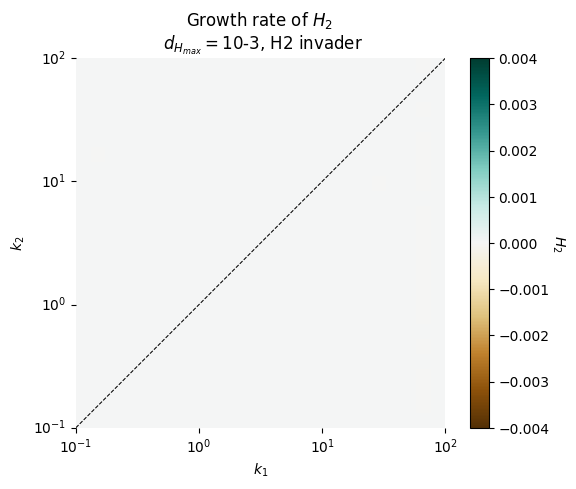

In [32]:
d_Hmax = "10-3"

fig, ax3 = plt.subplots()
ticks = np.append(k_1_range, 10)
ax3 = sns.heatmap((slopeH2), cmap="BrBG", square=True, cbar=False, vmin=-0.004, vmax=0.004)
cbar3 = ax3.figure.colorbar(ax3.collections[0])
cbar3.set_label('$H_2$', rotation=270, labelpad=12)
ax3.set_xticks(np.linspace(0, len(k_1_range), 4))
ax3.set_yticks(np.linspace(0, len(k_1_range), 4))
ax3.invert_yaxis()
ax3.set_xticklabels(("$10^{-1}$", "$10^{0}$", "$10^{1}$","$10^{2}$"), rotation=0)
ax3.set_yticklabels(("$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"))
#plt.grid(color='black', linewidth=0.5, linestyle='--')
ax3.plot([0, len(k_1_range)], [0, len(k_1_range)], color="black", linestyle="--", linewidth=0.75)
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')
plt.title('Growth rate of $H_2$ \n $d_{H_{max}} = $' + str(d_Hmax) + ', H2 invader')


Text(0.5, 1.0, '$d_{max} = $ 0.01')

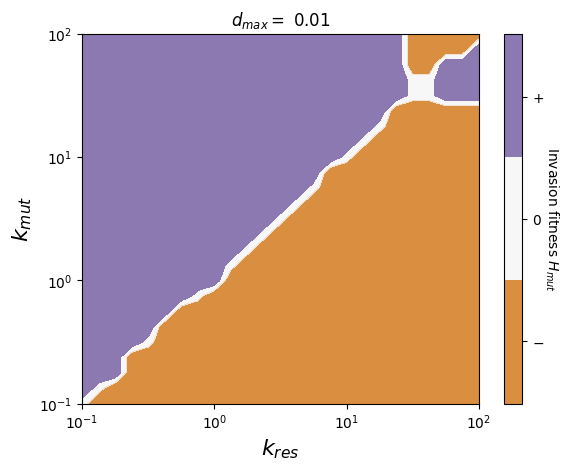

In [29]:
invSlope = np.copy(slopeH2)
invSlope[invSlope <= -0.00005] = -1
for i in range(len(invSlope)):
    for j in range(len(invSlope[i])):
        if (invSlope[i][j] != -1) and (invSlope[i][j] < 0.00005) and (invSlope[i][j] > -0.00005):
            invSlope[i][j] = 0
for i in range(len(invSlope)):
    for j in range(len(invSlope[i])):
        if ((invSlope[i][j] >= 0.00005)):
            invSlope[i][j] = 1

fig, ax = plt.subplots()
im = plt.contourf(invSlope, cmap="PuOr", levels=np.linspace(-1, 1, 4), alpha=0.8)
cbar = fig.colorbar(im)
cbar.set_ticks([-0.66, 0, 0.66])
cbar.set_ticklabels(["$-$","$0$","$+$"])
cbar.set_label('Invasion fitness $H_{mut}$', rotation=270, labelpad=12)
#plt.plot([0, 99], [0, 99], color="black", linestyle="--", linewidth=0.5, alpha = 0.5)
ax.set_xticks(np.linspace(0, len(k_1_range)-1, 4))
ax.set_yticks(np.linspace(0, len(k_1_range)-1, 4))
ax.set_xticklabels(("$10^{-1}$", "$10^{0}$", "$10^{1}$","$10^{2}$"), rotation=0)
ax.set_yticklabels(("$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"))
ax.set_xlabel('$k_{res}$', fontsize=16)
ax.set_ylabel('$k_{mut}$', fontsize=16)
ax.set_title("$d_{max} = $ " + str(d_Hmax1))

In [4]:
def find_extrema(x,n):
    """ returns an array with n extreme values of x"""
    
    min_index = signal.argrelmin(x)[0]         # create array with indices of local minima of x
    max_index = signal.argrelmax(x)[0]         # create array with indices of local maxima of x
    
    ext_index = np.append(min_index,max_index) # array with indices of local extrema in x
    ext_index = np.sort(ext_index)             # sort array (alternating minima and maxima)
    extrema = x[ext_index]                     # array with the actual values of the extrema
       
    if len(extrema) == 0:                      # if all values in x are the same and no extremum is found:
        extrema = np.append(extrema,x[-1])     #   return last value of x in this case
    while len(extrema) < n:                    # if less than n extrema have been found:
        extrema = np.append(extrema,extrema[0])#   repeat last extremum until array has n elements
    while len(extrema) > n:                    # if more than n extrema have been found:
        extrema = np.delete(extrema,-1)        #   delete elements until arrays has n elements
        
    return extrema

In [16]:
t_end = 25000
number_steps = 25000
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
k_1 = 5
k_2 = 5
d_Hmax1 = 10**-3
d_Hmax2 = 10**-3
# k_range = np.geomspace(10**2, 10**3, 250) #1000
d_Hmax_range = np.geomspace(10**-3, 10**2, 25) #1000

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]

num_extr = 12 # set number of maxima to be found

Ax_extr = []
Ay_extr = []
H1x_extr = []
H1y_extr = []
H2x_extr = []
H2y_extr = []

var = []

i = 0

for d_Hmax1 in tqdm(d_Hmax_range):
    var = integ.odeint(slow, var0, t)

    # t_end = 75000
    # number_steps = 75000
    # t2 = np.linspace(0, t_end, number_steps)
    
    # var00 = [var[-1,0], var[-1,1], var[-1,2], var[-1,3], var[-1,4], var[-1,5], 10**-6, 10**-6, 0, 0, 0, 0]
    # var = integ.odeint(slow, var00, t2)

    Ax_extr.append(find_extrema((var[-500:-1,2]),num_extr))
    Ay_extr.append(find_extrema((var[-500:-1,3]),num_extr))
    H1x_extr.append(find_extrema((var[-500:-1,4]),num_extr))
    H1y_extr.append(find_extrema((var[-500:-1,5]),num_extr))
    H2x_extr.append(find_extrema((var[-500:-1,6]),num_extr))
    H2y_extr.append(find_extrema((var[-500:-1,7]),num_extr))

    i += 1

# np.savetxt("./data/crowding/growthrate/H1Slope.csv", slopeH1, delimiter=",")
# np.savetxt("./data/crowding/growthrate/H2Slope.csv", slopeH2, delimiter=",")

100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


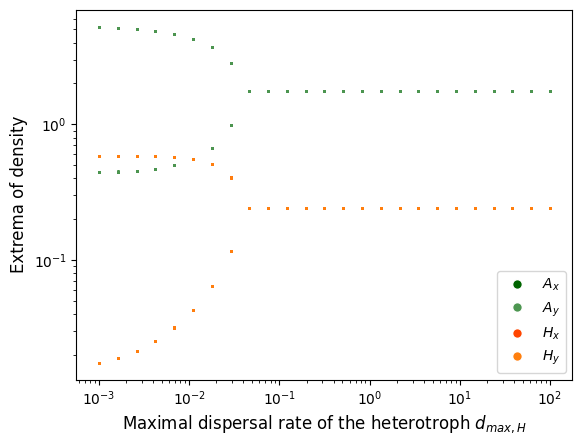

In [17]:
plt.plot(d_Hmax_range, Ax_extr, ".", markersize = 2, color="darkgreen")
plt.plot(d_Hmax_range, Ay_extr, ".", markersize = 2, color="#4D9651")
plt.plot(d_Hmax_range, H1x_extr, ".", markersize = 2, color="orangered")
plt.plot(d_Hmax_range, H1y_extr, ".", markersize = 2, color="#FF7F0E")#, alpha = 0.5)
# plt.plot(d_Hmax_range, H2x_extr, ".", markersize = 2, color="#1F77B4")
# plt.plot(d_Hmax_range, H2y_extr, ".", markersize = 2, color="#1F77B4", alpha = 0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Maximal dispersal rate of the heterotroph $d_{max, H}$", fontsize=12)
plt.ylabel("Extrema of density", fontsize=12)
#plt.ylim(10**-6,10**1)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='$A_x$', markerfacecolor='darkgreen', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='$A_y$', markerfacecolor='#4D9651', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='$H_x$', markerfacecolor='orangered', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='$H_y$', markerfacecolor='#FF7F0E', markersize=7)
    #Line2D([0], [0], marker='o', color='w', label='$H_{res}$', markerfacecolor='#FF7F0E', markersize=7),
    #Line2D([0], [0], marker='o', color='w', label='$H_{mut}$', markerfacecolor='#1F77B4', markersize=7)
]
plt.legend(handles=legend_elements, loc='lower right')

#plt.title("$d_{max, H} = $" + str(d_Hmax1) + ", $c_{mut} = $" + str(c_2))
#plt.title("$c_{res} = $" + str(c_1) + ", $c_{mut} = $" + str(c_2))